In [1]:
import pandas as pd
df = pd.read_csv('/Users/varunjoshi/Documents/Python/STIA_458/stiaFinalProject/test_set.csv')
df.head()

,Region,Title,Description
0,Africa,NaN,exam caus consequ forc migrat focus particular...
1,Africa,NaN,it underli aim familiar recent trend histor sc...
2,Africa,NaN,take look polit africa len fiction film our d...
3,Africa,NaN,what africa how africa written how africa writ...
4,Africa,NaN,there recent resurg inter-st cooper africa sec...


In [2]:
from io import StringIO
col = ['Region', 'Description']
df = df[col]
df = df[pd.notnull(df['Description'])]
df.columns = ['Region', 'Description']
df['category_id'] = df['Region'].factorize()[0]
category_id_df = df[['Region', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Region']].values)
df.head()

,Region,Description,category_id
0,Africa,exam caus consequ forc migrat focus particular...,0
1,Africa,it underli aim familiar recent trend histor sc...,0
2,Africa,take look polit africa len fiction film our d...,0
3,Africa,what africa how africa written how africa writ...,0
4,Africa,there recent resurg inter-st cooper africa sec...,0


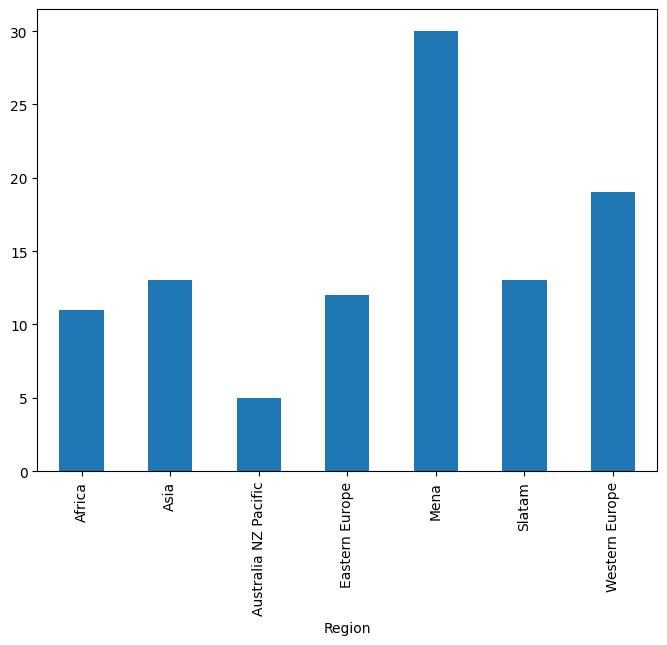

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Region').Description.count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Description).toarray()
labels = df.category_id
features.shape

(103, 449)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 5
for Region, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Region))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Africa':
  . Most correlated unigrams:
. trade
. moment
. cont
. africa
. african
  . Most correlated bigrams:
. 20th centuri
. world war
. lat american
. unit state
. case studi
# 'Asia':
  . Most correlated unigrams:
. asian
. interact
. skill
. life
. asia
  . Most correlated bigrams:
. north africa
. 20th centuri
. south asia
. unit state
. polit economi
# 'Australia NZ Pacific':
  . Most correlated unigrams:
. aftermath
. close
. deep
. affair
. strateg
  . Most correlated bigrams:
. region intern
. world war
. climat chang
. foreign polici
. role world
# 'Eastern Europe':
  . Most correlated unigrams:
. elect
. eastern
. russia
. soviet
. russian
  . Most correlated bigrams:
. lat american
. polit econom
. lat america
. climat chang
. answer question
# 'Mena':
  . Most correlated unigrams:
. east
. muslim
. middl
. isra
. arab
  . Most correlated bigrams:
. lat american
. north africa
. arab spring
. east north
. middl east
# 'Slatam':
  . Most correlated unigrams:
. industri


In [10]:
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Region'], random_state = 0)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Region'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

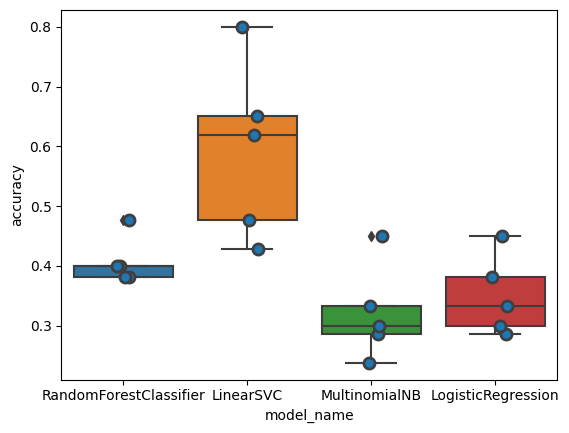

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [13]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.594762
LogisticRegression        0.350000
MultinomialNB             0.321429
RandomForestClassifier    0.407619
Name: accuracy, dtype: float64

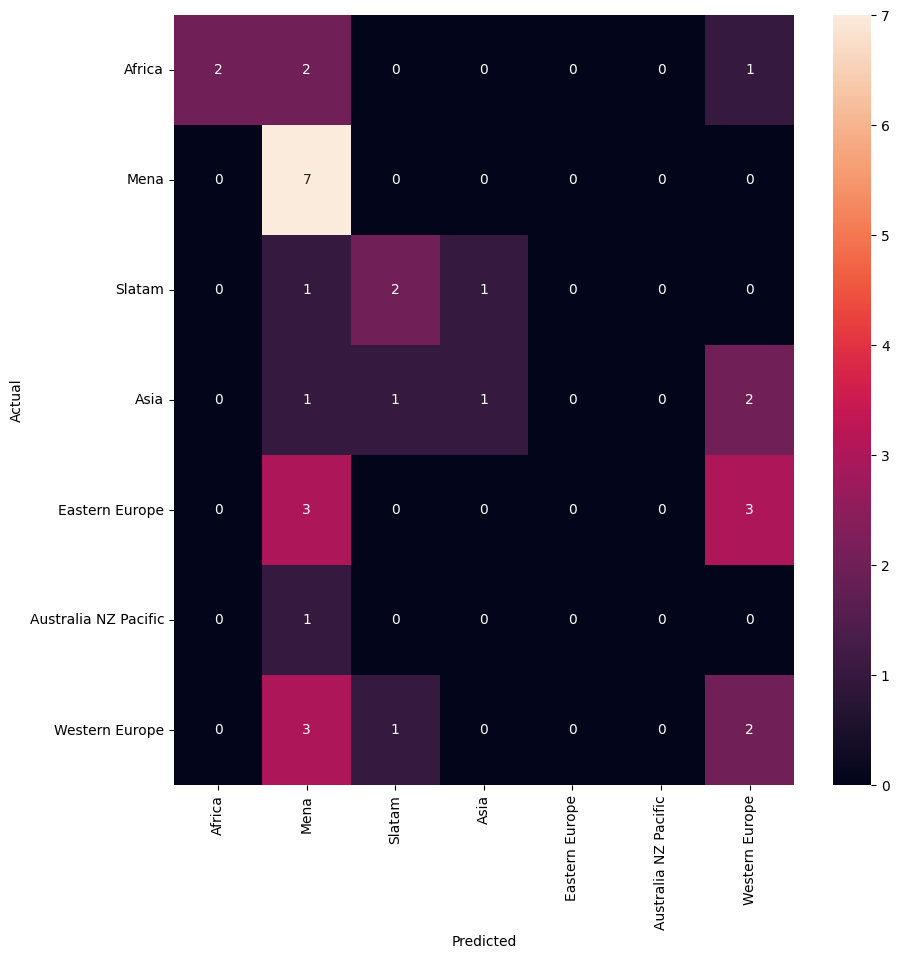

In [14]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Region.values, yticklabels=category_id_df.Region.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Region'].unique()))

                      precision    recall  f1-score   support

              Africa       1.00      0.40      0.57         5
                Mena       0.39      1.00      0.56         7
              Slatam       0.50      0.50      0.50         4
                Asia       0.50      0.20      0.29         5
      Eastern Europe       0.00      0.00      0.00         6
Australia NZ Pacific       0.00      0.00      0.00         1
      Western Europe       0.25      0.33      0.29         6

            accuracy                           0.41        34
           macro avg       0.38      0.35      0.31        34
        weighted avg       0.40      0.41      0.35        34



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.